In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys

sys.path.append("../")

# Training generative model on moons dataset

> The objective of this notebook is to train a generative model on the [moons dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html). The model used is a Variational Autoencoder (VAE) with a simple architecture, trained without and with conditioning on moon identity. The code is written in PyTorch, extended with Lightning and Hydra for training and configuration management.

> This repository was based on [Lightning Hydra Template](https://github.com/ashleve/lightning-hydra-template).


## Introduction

This notebook presents an exploration of training generative models on the moons dataset, with a particular focus on leveraging the Variational Autoencoder (VAE) framework. The moons dataset, despite its simplicity, offers a two-dimensional, non-linear pattern that poses a challenge for generative models. Variational Autoencoders are a class of generative models that learn a probabilistic mapping from a latent space to the data space, allowing for both efficient data compression and generation. VAEs differ from traditional autoencoders by introducing a probabilistic interpretation of the latent variables, which enables them to generate new, unseen samples by sampling from the learned latent distribution.

The aim of this report is to train a VAE on the moons dataset and analyze its generative performance, by reviewing the quality of the generated samples and the learned latent space. Additionally, it explores the impact of conditioning the VAE on the moon identity on the generative performance.


## Variational Autoencoders (VAEs)

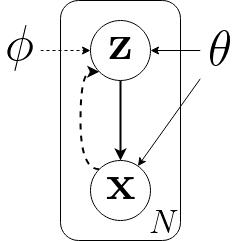

Variational Autoencoders (VAEs) are a class of generative models belonging to the family of **Latent Variable Models**. These models are based on an assumption that the data $\mathcal{X}$ is *generated* from a continuous latent variable $\mathcal{Z}$, which is not directly observed, via a probabilistic process. This involves specifying a joint distribution over the observed and latent variables $P(\mathbf{x},\mathbf{z})$

$$P(\mathbf{x},\mathbf{z})=P(\mathbf{x} | \mathbf{z})P(\mathbf{z})$$

where $P(\mathbf{z})$ is the prior distribution over the latent variables and $P(\mathbf{x} | \mathbf{z})$ is the likelihood of the data given the latent variables. Here, we assume that both distributions are parameterized by $\theta$ and their probability density functions are continuous. In VAEs, the dependency of the data $\mathbf{x}$ on the latent variables $\mathbf{z}$ is modeled by a neural network with parameters $\theta$, which is referred to as **the decoder** $P_\theta(\mathbf{x} | \mathbf{z})$.

In this setup, $P(\mathbf{x})$ can be obtained by marginalizing out the latent variables:

$$P(\mathbf{x})=\int P_\theta(\mathbf{x} | \mathbf{z})P(\mathbf{z})d\mathbf{z}$$

The objective of training latent variable model is to find the parameters $\theta$ that **maximize the likelihood of the observed data**. However, computing the likelihood $P(\mathbf{x})$ is intractable in most cases, as it involves marginalizing over the latent variables. To address this issue, VAEs introduce an **approximate inference model** $Q_\phi(\mathbf{z} | \mathbf{x})$ that approximates the true posterior $P(\mathbf{z} | \mathbf{x})$. This model, often referred to as **the encoder**, is parameterized by $\phi$ and is used to infer the latent variables given the observed data.

In this setup, the objective can be formulated as below:

$$
\begin{align*}
    \log p_\theta\left(\mathbf{x}\right) & = \mathbb{E}_{\mathbf{z} \sim q_\phi\left(\mathbf{z} | \mathbf{x}\right)} \left[\log p_\theta\left(\mathbf{x}\right)\right] & \text{$p_\theta\left(\mathbf{x}\right)$ is independent of $\mathbf{z}$}\\
    & = \mathbb{E}_{\mathbf{z}}\left[\log\frac{p_\theta\left(\mathbf{x} | \mathbf{z}\right)p\left(\mathbf{z}\right)}{p\left(\mathbf{z} | \mathbf{x}\right)}\right] & \text{Bayes Theorem}\\
    & = \mathbb{E}_{\mathbf{z}}\left[\log\frac{p_\theta\left(\mathbf{x} | \mathbf{z}\right)p\left(\mathbf{z}\right)}{p\left(\mathbf{z} | \mathbf{x}\right)}\frac{q_\phi\left(\mathbf{z} | \mathbf{x}\right)}{q_\phi\left(\mathbf{z} | \mathbf{x}\right)}\right] & \text{multiply by 1}\\
    & = \mathbb{E}_{\mathbf{z}}\left[\log p_\theta\left(\mathbf{x} | \mathbf{z}\right)\right] - \mathbb{E}_{\mathbf{z}}\left[\log \frac{q_\phi\left(\mathbf{z} | \mathbf{x}\right)}{p\left(\mathbf{z}\right)}\right] + \mathbb{E}_{\mathbf{z}}\left[\log \frac{q_\phi\left(\mathbf{z} | \mathbf{x}\right)}{p\left(\mathbf{z} | \mathbf{x}\right)}\right] & \text{logarithm}\\
    & = \underbrace{\mathbb{E}_{\mathbf{z}}\left[\log p_\theta\left(\mathbf{x} | \mathbf{z}\right)\right] - D_{KL}\left(q_\phi\left(\mathbf{z} | \mathbf{x}\right)\| p\left(\mathbf{z}\right)\right)}_{\mathcal{L}\left(\mathbf{x}, \theta, \phi\right)} + \underbrace{D_{KL}\left(q_\phi\left(\mathbf{z} | \mathbf{x}\right)\| p\left(\mathbf{z} | \mathbf{x}\right)\right)}_{\ge 0}\\
\end{align*}
$$

Calculating the KL divergence between the true posterior and its approximation is intractable, but it is always non-negative. Therefore, the objective function $\mathcal{L}\left(\mathbf{x}, \theta, \phi\right)$ is a lower bound on the log-likelihood of the data. This lower bound is known as the **Evidence Lower Bound (ELBO)** and is maximized during training. Intuitively, the ELBO consists of two terms: **the reconstruction loss**, which measures the difference between the input data and the reconstructed data, and **the KL divergence** between the approximate posterior and the prior. Usually, the prior is chosen to be a standard normal distribution $\mathcal{N}(0, \mathbf{I})$.

### Reparametrization trick

One of the challenges in training VAEs is that backpropagation can't flow through the sampling operation in the encoder. To address this issue, the **reparametrization trick** is used, which involves sampling from a simple distribution (e.g., standard normal) ($\epsilon \sim \mathcal{N}(0,\mathbf{I})$) and transforming the samples to the desired distribution using the parameters predicted by the encoder.

$$\mathbf{z} = \mathbf{\mu}(\mathbf{x}) + \mathbf{\sigma}(\mathbf{x}) \odot \epsilon$$

The reparametrization allows gradients to flow through the encoder, enabling end-to-end training of the VAE.


## Conditional Variational Autoencoders (CVAEs)

Conditional Variational Autoencoders (CVAEs) are an extension to the standard VAE framework that allows for conditioning the generative model on additional information. In CVAEs, both the encoder and the decoder are conditioned on the auxiliary information, such as class labels, denoted as $\mathbf{y}$. The inclusion of conditioning allows more control over the generative process.

In a CVAE, the joint distribution of the observed data is expressed as:

$$P(\mathbf{x}, \mathbf{z} | \mathbf{y}) = P(\mathbf{x} | \mathbf{z}, \mathbf{y})P(\mathbf{z} | \mathbf{y})$$

Here, the prior distribution $P(\mathbf{z} | \mathbf{y})$ and the likelihood $P(\mathbf{x} | \mathbf{z}, \mathbf{y})$ are conditioned on the auxiliary information $\mathbf{y}$. The formulation of the ELBO in CVAEs is similar to the standard VAE, but the encoder and decoder are conditioned on the auxiliary information. In practice, the conditioning can be achieved by concatenating the auxiliary information to the input data and the latent variables.


## Dataset and preprocessing

The moons dataset is a synthetic dataset generated using the `make_moons` function from `scikit-learn`. It consists of two interleaving half circles, making it a non-linear dataset. Its key parameters are:
- `n_samples`: the total number of samples to generate
- `noise`: the standard deviation of Gaussian noise added to the data
- `random_state`: the random seed used for generating the data

During initial exploration, applying normalization didn't affect the performance of the model due to the original scale of the data. Therefore, no preprocessing is applied to the moons dataset.

In [ ]:
from plotly.subplots import make_subplots
from sklearn.datasets import make_moons

from src.utils.visualize import visualize_data

sizes = [100, 1000, 10000]
noises = [0, 0.1, 0.2, 0.3, 0.4, 0.5]

fig = make_subplots(
    rows=len(sizes),
    cols=len(noises),
    subplot_titles=[f"Size: {size}, Noise: {noise}" for size in sizes for noise in noises],
)


for n_idx, noise in enumerate(noises, start=1):
    for s_idx, size in enumerate(sizes, start=1):
        X, y = make_moons(n_samples=size, noise=noise)

        scatter = visualize_data(X, y, title=f"Size: {size}, Noise: {noise}")
        for trace in range(len(scatter["data"])):
            fig.append_trace(scatter["data"][trace], row=s_idx, col=n_idx)

fig.update_layout(
    height=250 * len(sizes),
    width=250 * len(noises),
    title="Moons dataset params",
    showlegend=False,
)
fig.show()

### Implementation details

The Moons dataset is created within a Lightning `DataModule` class, which is responsible for loading and preprocessing the data. The `MoonsDataModule` class is defined as below. The dataset is split into training, validation and test dataset, with a 60:20:20 ratio. Therefore, the initial dataset size is set to 2000 samples.


In [ ]:
from IPython.display import Code

Code(filename="../src/data/moons_datamodule.py", language="python")

## Model architecture

### VAE

The VAE model is implemented using PyTorch and Lightning. The model architecture consists of an encoder and a decoder, both implemented as simple 1-hidden layer feedforward neural networks. The encoder maps the input data to the latent space, while the decoder reconstructs the input data from the latent space. The latent space is parameterized by the mean and log-variance of the Gaussian distribution.

$$\mu, \rho = \text{encoder}(\mathbf{x}); \mathbf{z} \sim \mathcal{N}(\mu, e^{\rho}); \mathbf{x}_{\text{recon}} = \text{decoder}(\mathbf{z})$$

The neural networks use ReLU activation functions except for the output layers of both the encoder and decoder, which use linear activation functions to ensure the output is unconstrained. The implementation leverages the reparametrization trick to enable end-to-end training of the VAE, with a tuned epsilon value to control the sampling noise.

The model is trained using the ELBO loss, which consists of the reconstruction loss and the KL divergence between the approximate posterior and the prior.

> The ELBO loss implementation used in this project features an additional scaling factor ($\beta$), which could be used to control the importance of the KL divergence term in the loss. The $\beta$ parameter affects the trade-off between the reconstruction loss and the KL divergence, which can enforce a more disentangled latent space.

The model is implemented as a standard torch module, with the encoder and decoder defined as separate modules.


In [ ]:
Code(filename="../src/models/components/vae.py", language="python")

### CVAE

The Conditional Variational Autoencoder (CVAE) extends the VAE model to include conditioning on the moon identity. The moon identity is a binary variable that indicates the origin of the data point (moon 0 or moon 1). The CVAE model architecture is similar to the VAE, but the encoder and decoder are conditioned on the moon identity. The moon identity is concatenated to the input data and the latent variables.

$$\mu, \rho = \text{encoder}(\mathbf{x}, \mathbf{y}); \mathbf{z} \sim \mathcal{N}(\mu, e^{\rho}); \mathbf{x}_{\text{recon}} = \text{decoder}(\mathbf{z}, \mathbf{y})$$

The loss function used for the CVAE is formulated similarly to the VAE.

The CVAE model is implemented as a torch module, inheriting from the VAE model and re-using the encoder and decoder modules. The model is defined as below.


In [ ]:
Code(filename="../src/models/components/cvae.py", language="python")

## Training

The training of the VAE and CVAE models is done in an unsupervised setup, where the models are trained to reconstruct the input data and learn a meaningful latent representation. Both the encoder and the decoder are trained jointly, using the ELBO loss as the objective function. Therefore, the training process could be easily implemented in plain PyTorch as below:


In [ ]:
import torch
from tqdm.auto import trange

from src.data.moons_datamodule import MoonsDataModule
from src.models.components.vae import VAE, Decoder, Encoder, VAELoss

MAX_EPOCHS = 100

datamodule = MoonsDataModule(data_dir="../", batch_size=64)
datamodule.prepare_data()
datamodule.setup()

encoder = Encoder(input_dim=2, hidden_dims=32, latent_dim=32)
decoder = Decoder(input_dim=32, hidden_dims=32, output_dim=2)
model = VAE(encoder, decoder, eps_w=0.1)

loss_fn = VAELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in trange(MAX_EPOCHS):
    model.train()

    for x, y in datamodule.train_dataloader():
        optimizer.zero_grad()

        x_hat = model(x, y=None)
        loss, _ = loss_fn(x_hat, x)
        loss.backward()

        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_loss = 0
        for x, y in datamodule.val_dataloader():
            x_hat = model(x, y=None)
            loss, _ = loss_fn(x_hat, x)
            val_loss += loss
        val_loss /= len(datamodule.val_dataloader())
        print(f"Epoch: {epoch}, Val loss: {val_loss.item()}")

However, to allow for easier experimentation, training process logging and evaluation, the training is done using the PyTorch Lightning framework. `GenerativeLitModule` is a Lightning module that encapsulates the training and evaluation logic for both the VAE and CVAE models. The module is responsible for setting up, training and evalutaion of the model. It also handles learning rate scheduling (reducing the learning rate on a plateau).


In [ ]:
Code(filename="../src/models/generative_module.py", language="python")

### Implementation details

The training process is managed using Hydra, allowing for organized configuration management and easy experimentation with different hyperparameters. The configuration file `train.yaml` contains the master configuration for the training process, including the data parameters, model hyperparameters, training settings, and logging options.

The model training was conducted on a CPU, using the Adam optimizer. Each model was trained for maximum 1000 epochs, with early stopping based on the validation loss. The training process was monitored in Weights & Biases [generative_moons](https://wandb.ai/piotlinski/generative_moons) project.

In [ ]:
Code(filename="../configs/train.yaml", language="yaml")

## Evaluation

The evaluation of the generative models is done by analyzing the quality of the generated samples and the learned latent space. In this project, the evaluation is done by:
- Reviewing the value of the reconstruction loss (mean squared error)
- Analyzing the KL divergence term
- Visualizing the generated samples and comparing them to the original data
- Visualizing the learned latent space and the distribution of the latent variables (using UMAP)
- Exploring the influence of modifying the latent variables on the generated samples

## Results and discussion

This section presents the results of training the VAE and CVAE models, the hyperparameter optimization process, and the analysis of the influence of the dataset and probabilistic parameter on the generative performance of the models. They need to be reviewed in the context of the training visualizations on the Weights & Biases platform.


### Basic hyperparameter tuning

Using Hydra enables hyperparameter tuning using Optuna. In this report, the following list of basic hyperparameters values was searched:
- `model.optimizer.lr`: the learning rate of the optimizer (`1e-4` - `1e-1`)
- `data.batch_size`: the batch size used during training (`32`, `64`, `128`, `256`)
- `model.model.encoder.hidden_dims`: the size of the hidden layer in the encoder (`2`, `4`, ..., `128`)
- `model.model.decoder.hidden_dims`: the size of the hidden layer in the decoder (`2`, `4`, ..., `128`)
- `model.model.encoder.latent_dim`: the size of the latent space (`2`, `4`, ..., `128`)

The objective of the optimization was to minimize the mean squared error on the validation dataset. The optimization uses the TPE sampler, with 100 trials.

#### The influence of learning rate and batch size

According to the hyperparameter search, both the learning rate and the batch size did not have a significant impact on the performance of the model (except for the usual considerations for these hyperparameters). Across the reviewed range values, the models achieved similar performance, while other hyperparameters had a more significant impact on the quality of the reconstructions.

For the remaining experiments, the learning rate was set to `1e-3` and the batch size to `256`.

#### The influence of the model size and the latent space dimensionality

According to the hyperparameter search, the number of parameters in the model play a decisive role in the performance of the VAE model, showing the highest correlation with the reconstruction error. Most important role is played by the decoder hidden size and the latent space dimensionality: models with larger latent space and decoder hidden size achieved better performance. It is important to note, that both these values need to be increased together, as a large decoder hidden size without a corresponding increase in the latent space dimensionality does not improve the performance.

Interestingly, increasing the encoder size beyond `8` tends to degrade the performance of the VAE model, which might be connected to the problem of overfitting, as well as the excessive complexity of the model for the given dataset.

For an improperly tuned model, e.g. for very simple encoder and decoder configuration, the model was not able to learn the reconstructions, instead focusing on minimizing the KL divergence term. This resulted in a model with a very smooth latent space, but poor reconstruction.

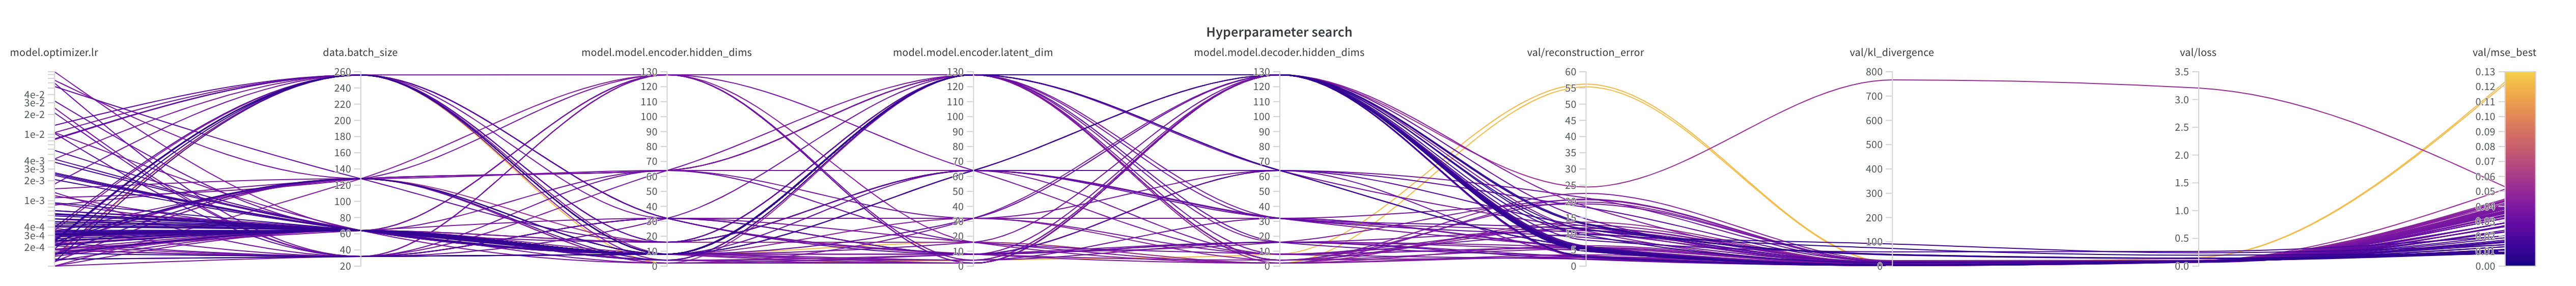

For a conditioned VAE (CVAE), the model training behaves entirely different. The model tends to provide satisfactory reconstructions for a wide range of hyperparameters, thanks to the added information about the moon identity.

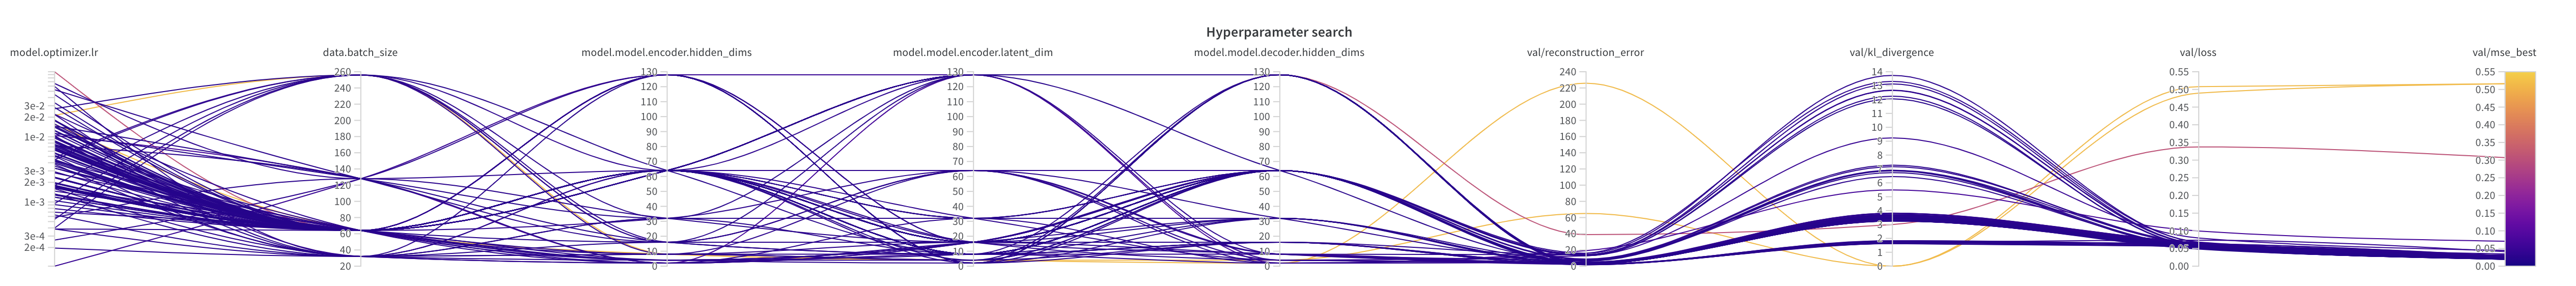

For the remaining experiments, the parameters of the neural network were chosen according to the VAE hyperparameter optimization results:
- `model.model.encoder.hidden_dims`: `8`
- `model.model.decoder.hidden_dims`: `128`
- `model.model.encoder.latent_dim`: `128`


### Influence of the dataset parameters

The second experiment focused on the analysis of how the dataset parameters (number of samples and noise level) influence the performance of the VAE model. The dataset parameters were varied in the following ranges:
- `data.n_samples`: the number of samples in the dataset (`200`, `2000`, `20000`)
- `data.noise`: the standard deviation of the Gaussian noise added to the data (`0.0`, `0.05`, `0.1`, ..., `0.3`)

The aim was to analyze how these variables affect the reconstruction error and the KL divergence term of the trained model.

A training dataset with more samples should improve the quality of the learned latent space and the reconstructions up to a certain point. Intuitively, given the simplicity of the dataset, a training subset containing `1000` samples should be sufficient to capture the underlying distribution. The search confirms this hypothesis, indicating slightly reduced overfitting for larger datasets. It is worth noting, that this also leads to reduced overall performance of the model, as for the smaller dataset, it was able to adjust better to the training data.

This effect is even more visible in the CVAE model, where the reconstruction error is similar for all dataset sizes, affected only by the noise level.

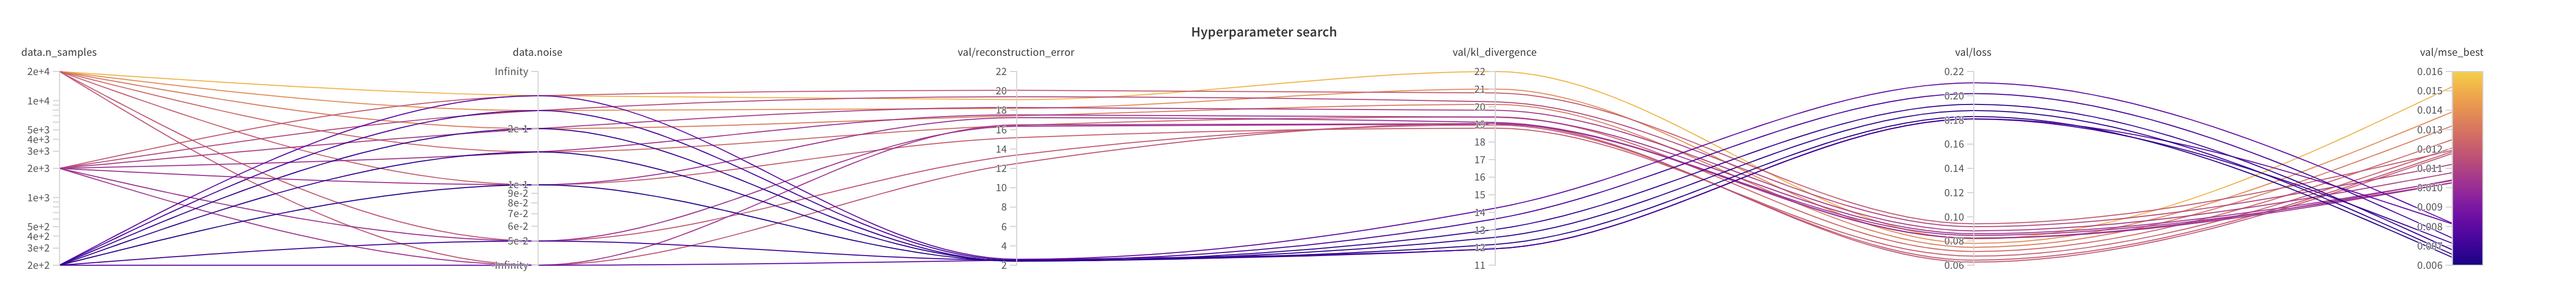

Due to the nature of the Variational Autoencoder, the model introduces some noise to the reconstructions, due to the KL divergence term. This causes the model to perform worse for a dataset with no noise, as it is not able to model this kind of data. The model performs best for small noise levels, which provide clear distinction between the clusters.


### Influence of the model's probabilistic parameters

The basic implementation of the Variational Autoencoder was extended with two additional parameters:
- `model.loss.beta`: the scaling factor for the KL divergence term in the loss function (`0.1` - `100.0`)
- `model.model.eps_w`: the weight of the epsilon value in the reparametrization trick (`0.001` - `1.0`)

During the initial experimentation, it was discovered that the default noise sampled from the standard normal distribution was too high, leading to posterior collapse (the model focusing on minimizing the KL divergence term instead of learning the reconstructions). By reducing the noise, the model is able to learn to reconstruct the input, at the cost of the latent space smoothness.

Decreasing the noise weight and the `beta` parameter reduces the influence of the KL divergence term on the loss function, leading to a more accurate reconstruction, with a less smooth latent space, prone to overfitting. On the other hand, 

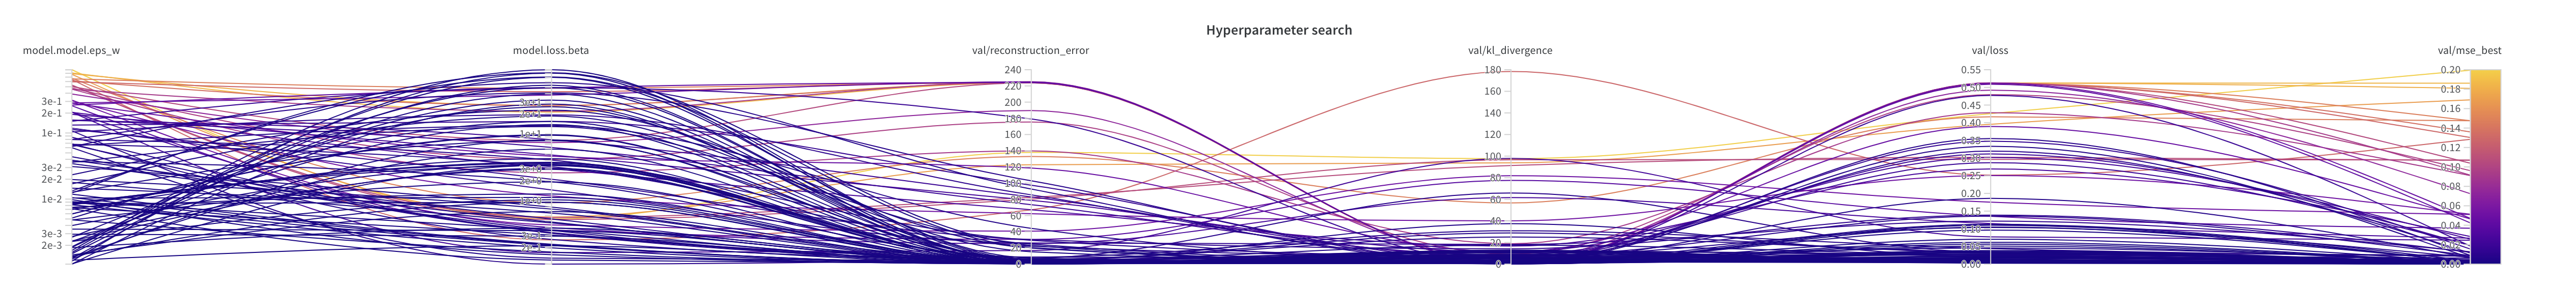

In the case of the CVAE model, excessive regularization of the latent space leads to posterior collapse quicker, as the model can utilize the moon identity to generate samples close to the training data. This results in the latent space very close to the prior distribution, without conveying valuable information about the data.


In [ ]:
import numpy as np
import torch
from hydra import compose, initialize
from hydra.utils import instantiate

from src.models.generative_module import GenerativeLitModule


def load_generative_lit_module(experiment: str, checkpoint: str, override_key: str = "model"):
    with initialize(version_base=None, config_path="../configs", job_name="explore"):
        cfg = compose(config_name="train", overrides=[f"{override_key}={experiment}"])
    model = instantiate(cfg.model.model)
    loss = instantiate(cfg.model.loss)
    return GenerativeLitModule.load_from_checkpoint(checkpoint, model=model, loss=loss)


data = "../data/moons_2000_0.15_42.npz"

data = np.load(data)
X, y = data["X"], data["y"]
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).int()

### Reconstructions and latent space visualization

After the hyperparameter optimization, the trained VAE and CVAE models were used to generate samples and compare them with the original data. This also involves visualizing the learned latent space by projecting it to a 2D space using UMAP. The visualization utilizes Plotly for interactive exploration of the latent space.


In [ ]:
Code(filename="../src/utils/visualize.py", language="python")

In [ ]:
vae_ckpt = "../logs/train/runs/2024-08-26_01-14-05/checkpoints/epoch_211.ckpt"
cvae_ckpt = "../logs/train/runs/2024-08-26_01-12-51/checkpoints/epoch_211.ckpt"
vae = load_generative_lit_module("vae", vae_ckpt, override_key="experiment").eval()
cvae = load_generative_lit_module("cvae", cvae_ckpt, override_key="experiment").eval()

#### Reconstructions

The reconstructions generated by the VAE and CVAE models are visually similar to the original data, capturing the underlying distribution of the moons dataset. The models are able to generate samples that resemble the input data, with some noise introduced due to the probabilistic nature of the VAE. The boundary between both clusters is clearer for the CVAE model, which benefits from the additional conditioning on the moon identity.

In [ ]:
from src.utils.visualize import visualize_data

visualize_data(X.numpy(), y.numpy(), title="Original data").show()

with torch.no_grad():
    X_vae, _ = vae(X, y=y)
visualize_data(X_vae.numpy(), y.numpy(), title="VAE generated data").show()

with torch.no_grad():
    X_cvae, _ = cvae(X, y)
visualize_data(X_cvae.numpy(), y.numpy(), title="CVAE generated data").show()

#### Latent space

The latent space learned by the VAE and CVAE models is visualized using UMAP, which projects the high-dimensional latent space to a 2D space. The latent space of the VAE model is continuous and smooth, but the moons are clearly visible as separate clusters in the latent space. On the other hand, conditioning added in the CVAE model results in an overlapping latent space, where the moons are not as clearly separated. This is due to the model learning to generate samples based on the moon identity, rather than the underlying distribution of the data.

In [ ]:
from src.utils.visualize import visualize_latents

with torch.no_grad():
    _, z_vae = vae(X, y=y)
visualize_latents(z_vae["z"].numpy(), y.numpy(), title="VAE latent space").show()

with torch.no_grad():
    _, z_cvae = cvae(X, y)
visualize_latents(z_cvae["z"].numpy(), y.numpy(), title="CVAE latent space").show()

### Latent space exploration

The final experiment focused on exploring the learned latent space of the VAE and CVAE models. The process involves generating latent representations of all samples in the dataset and collecting the basic statistics for each of the latent variable dimensions. Then, a median value of the latent space is calculated as the reference point, and the influence of modifying each of the latent variables within the minimum and the maximum is shown by reconstructing the point and reviewing how those changes appear in the latent space.

To make the analysis easier, the models used in this experiment are using smaller latent space dimensionality (`8`), which allows for easier interpretation of the latent space.

In [ ]:
# models with lower latent dimensionality
vae_ckpt = "../logs/train/runs/2024-08-25_22-40-59/checkpoints/epoch_325.ckpt"
cvae_ckpt = "../logs/train/runs/2024-08-25_22-41-19/checkpoints/epoch_594.ckpt"
vae = load_generative_lit_module("vae", vae_ckpt).eval()
cvae = load_generative_lit_module("cvae", cvae_ckpt).eval()

#### Influence on the reconstructions

For the VAE model, modifying the latent variables within the range of the minimum and maximum values results in transition between the samples across the entire dataset. On the other hand, conditioning on the moon identity in the CVAE model results in a more localized transition, where the reconstructions vary within a single moon, rather than all the data.

In [ ]:
@torch.no_grad()
def explore_reconstructions(vae, X, y, title, conditioning=None):
    fig = visualize_data(X.numpy(), y.numpy(), title=title)

    latents = vae.model(X, y.unsqueeze(-1))[1]["z"]
    mins, maxs, medians = (
        latents.min(dim=0).values,
        latents.max(dim=0).values,
        latents.median(dim=0).values,
    )

    for idx, (min_, max_) in enumerate(zip(mins, maxs)):
        vis_latents = []
        latent_arange = torch.linspace(min_, max_, 10)
        for val in latent_arange:
            new_latent = medians.clone()
            new_latent[idx] = val
            vis_latents.append(new_latent)
        vis_latents = torch.stack(vis_latents)
        if conditioning is not None:
            vis_latents = torch.cat(
                [vis_latents, torch.Tensor([conditioning]).repeat(vis_latents.shape[0], 1)], dim=1
            )
        vis_recs = vae.model.decoder(vis_latents).numpy()
        fig.add_scatter(
            x=vis_recs[:, 0], y=vis_recs[:, 1], mode="lines+markers", name=f"Latent {idx}"
        )

    return fig

In [ ]:
explore_reconstructions(vae, X, y, title="VAE: Both moons").show()

In [ ]:
explore_reconstructions(
    cvae, X, y, title="CVAE: Both moons (conditioned: 0)", conditioning=0
).show()

In [ ]:
explore_reconstructions(
    cvae, X, y, title="CVAE: Both moons (conditioned: 1)", conditioning=1
).show()

#### Influence on the latent space

As expected, varying the latent variables results in points across the entire latent space; the nonlinear character of these changes is a result of the non-linear transformation in the UMAP projection.

In [ ]:
from src.utils.visualize import visualize_latents


@torch.no_grad()
def explore_latent_space(vae, X, y, title):
    latents = vae.model(X, y.unsqueeze(-1))[1]["z"]
    fig, reducer = visualize_latents(latents.numpy(), y.numpy(), title=title, return_reducer=True)
    mins, maxs, medians = (
        latents.min(dim=0).values,
        latents.max(dim=0).values,
        latents.median(dim=0).values,
    )

    for idx, (min_, max_) in enumerate(zip(mins, maxs)):
        vis_latents = []
        latent_arange = torch.linspace(min_, max_, 10)
        for val in latent_arange:
            new_latent = medians.clone()
            new_latent[idx] = val
            vis_latents.append(new_latent)
        vis_latents = torch.stack(vis_latents)
        embedding = reducer.transform(vis_latents.numpy())

        fig.add_scatter(
            x=embedding[:, 0], y=embedding[:, 1], mode="lines+markers", name=f"Latent {idx}"
        )

    return fig

In [ ]:
explore_latent_space(vae, X, y, title="VAE latent space Both moons").show()

In [ ]:
explore_latent_space(cvae, X, y, title="VAE latent space Both moons").show()

In [ ]:
# high beta
vae_ckpt = "../logs/train/runs/2024-08-26_01-27-46/checkpoints/epoch_112.ckpt"
cvae_ckpt = "../logs/train/runs/2024-08-26_01-27-48/checkpoints/epoch_211.ckpt"

vae = load_generative_lit_module("vae", vae_ckpt, override_key="experiment")
cvae = load_generative_lit_module("cvae", cvae_ckpt, override_key="experiment")

with torch.no_grad():
    x_hat, _ = vae.model(X, y=None)
visualize_data(x_hat.numpy(), y.numpy(), title="VAE").show()
explore_reconstructions(vae, X, y, title="VAE: Both moons").show()
explore_latent_space(vae, X, y, title="VAE latent space Both moons").show()

with torch.no_grad():
    x_hat, _ = cvae.model(X, y=y.unsqueeze(-1))
visualize_data(x_hat.numpy(), y.numpy(), title="CVAE").show()
explore_reconstructions(
    cvae, X, y, title="CVAE: Both moons (conditioned: 0)", conditioning=0
).show()
explore_reconstructions(
    cvae, X, y, title="CVAE: Both moons (conditioned: 1)", conditioning=1
).show()
explore_latent_space(cvae, X, y, title="CVAE latent space Both moons").show()

## Conclusion

This report presents the exploration of the process of training a generative model on the moons dataset. The experiments focused on analyzing the influence of the dataset parameters, the model hyperparameters, and the probabilistic parameters on the generative performance of the VAE and Conditional VAE (CVAE) models. The results indicate that the model's performance is influenced by the complexity of the neural network, the latent space dimensionality, the dataset size, and the noise level, as well as the weight parameter of the ELBO loss function and the weight of random noise in the reparametrization trick. The CVAE model benefits from the additional conditioning on the moon identity, which allows for more control over the generative process, however, it also reduces the separation between the moons in the latent space.

The analysis of the learned latent space and the influence of modifying the latent variables on the generated samples provides insights into the generative capabilities of the models. The VAE model learns a continuous and smooth latent space, while the CVAE model learns a more localized latent space, influenced by the moon identity. The latent space exploration shows that the models are able to generate samples that transition smoothly across the dataset, capturing the underlying distribution of the moons dataset.

Interesting challenges that occurred during this research were problems with posterior collapse, where the model generates reconstructions while ignoring the latent space, which is connected to the issue of balancing the noisiness of the latent space and the influence of the KL divergence term in the loss function. The CVAE model, on the other hand, is more prone to overfitting, as the model can generate samples close to the training data by utilizing the moon identity.